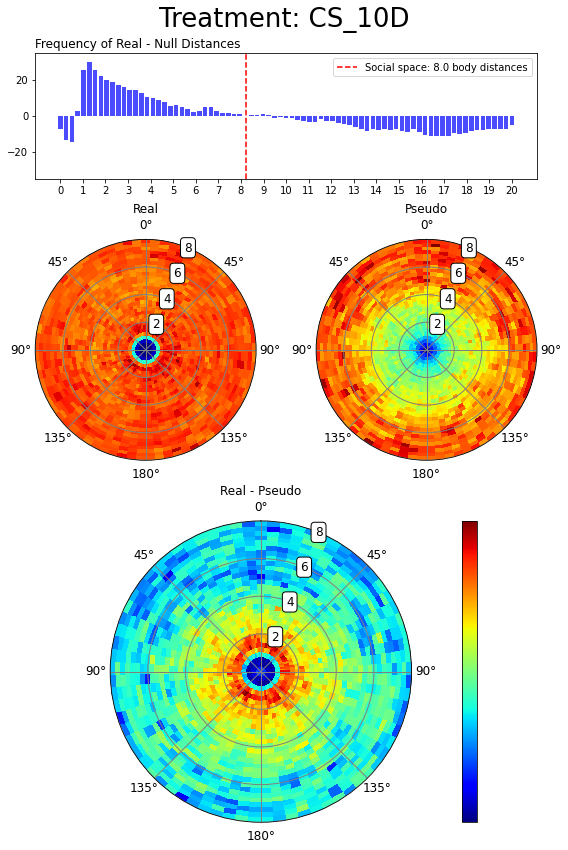

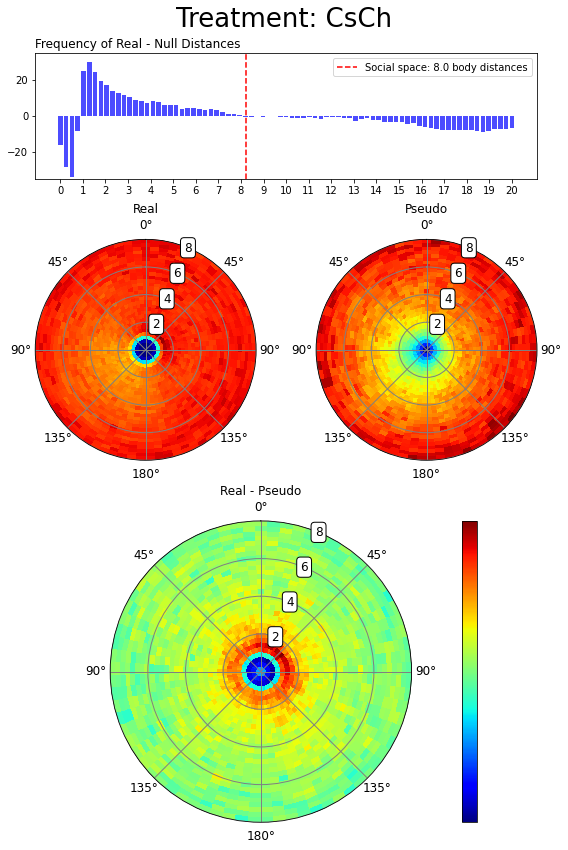

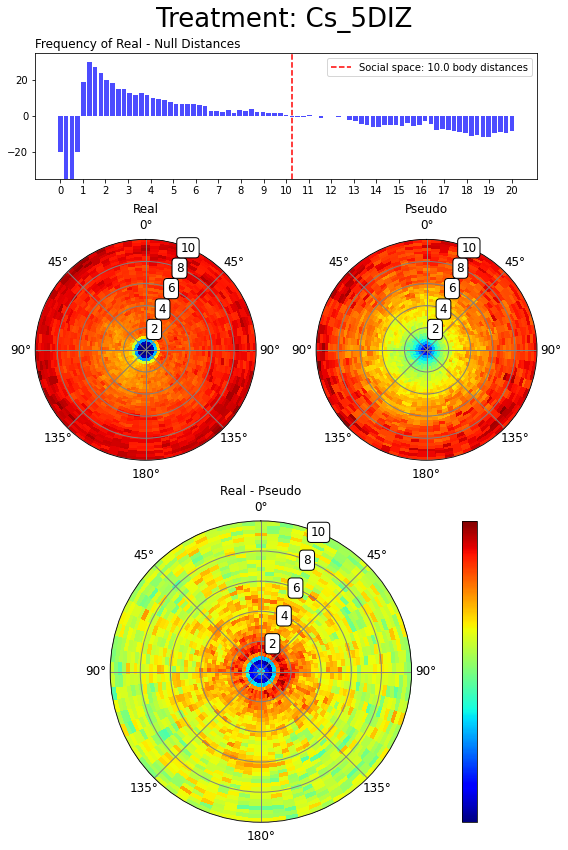

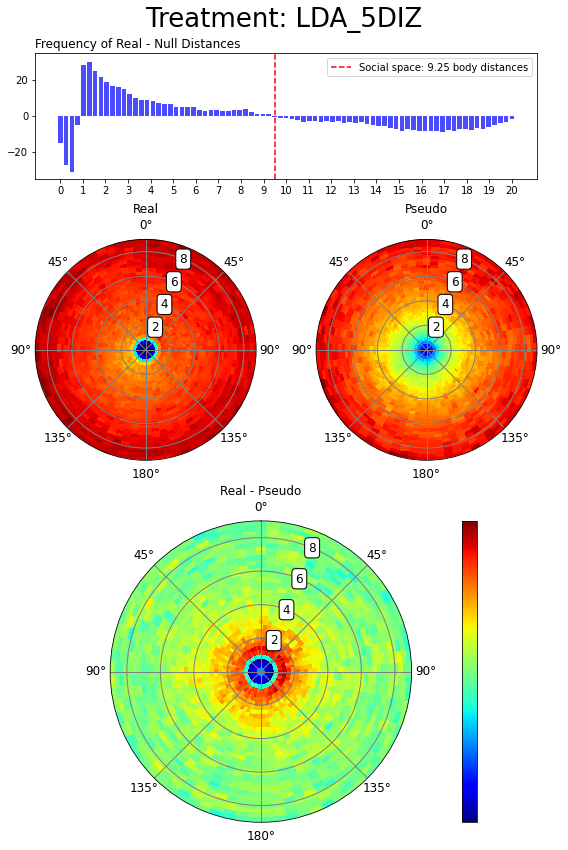

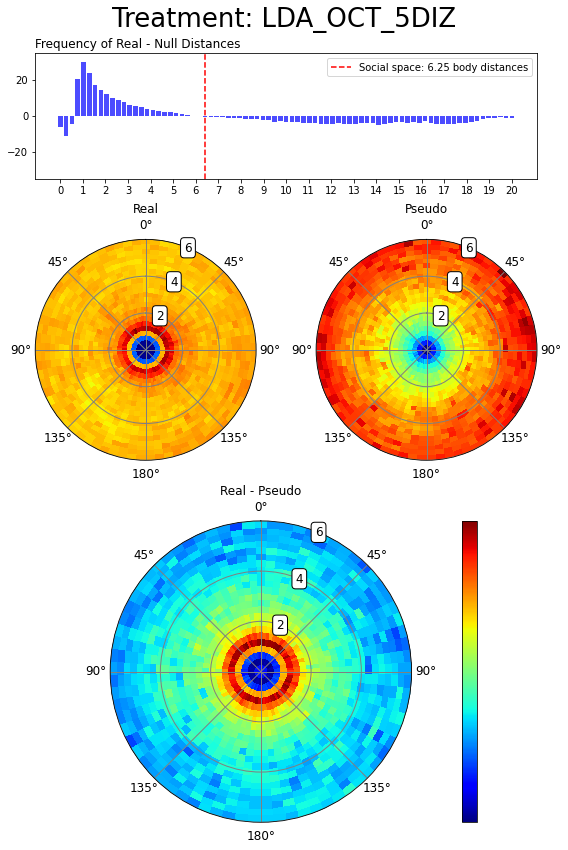

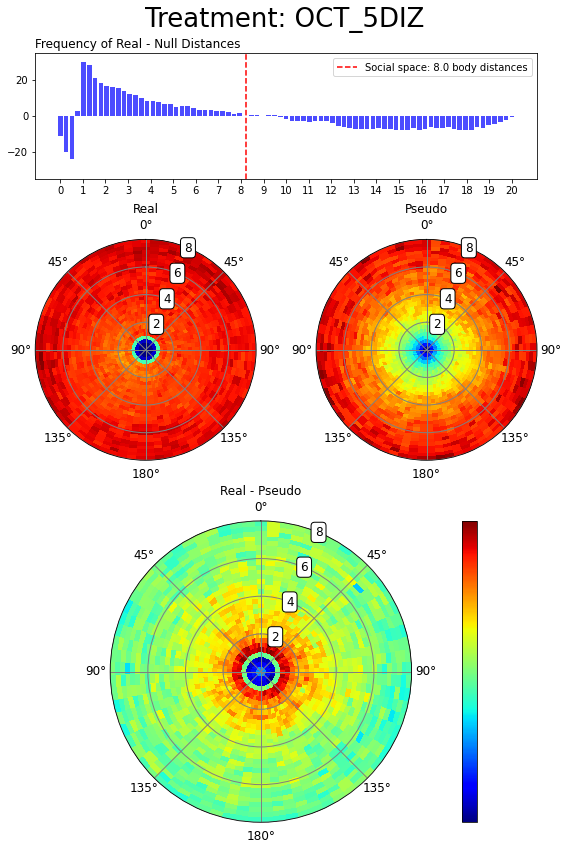

In [21]:
# %%
import itertools
import multiprocessing
import os
import random
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import settings
from src.utils import fileio


def plot_heatmap(histogram):
    """
    Need to fix this foo.
    add code that calculates MAX_DIST
    """

    degree_bins = np.linspace(-180, 180, 74)
    distance_bins = np.linspace(0, 20, 80)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"polar": True})
    img = ax.pcolormesh(np.radians(degree_bins), distance_bins, histogram, cmap="jet")
    ax.set_rgrids(np.arange(0, 20.251, 5.0), angle=0)
    ax.set_theta_offset(np.pi / 2)
    ax.grid(True)
    plt.title("")
    plt.tight_layout()
    plt.show()


def angledifference_nd(angle1, angle2):
    """Calculates the difference between two angles in degrees."""

    difference = angle2 - angle1
    adjustlow = difference < -180
    adjusthigh = difference > 180
    while any(adjustlow) or any(adjusthigh):
        difference[adjustlow] = difference[adjustlow] + 360
        difference[adjusthigh] = difference[adjusthigh] - 360
        adjustlow = difference < -180
        adjusthigh = difference > 180

    return difference


def group_space_angle_hist(group_paths):
    ANGLE_BIN = 5
    DISTANCE_BIN = 0.25
    DISTANCE_MAX = 20
    degree_bins, distance_bins = np.arange(-177.5, 177.6, ANGLE_BIN), np.arange(0.125, 19.8751, DISTANCE_BIN)
    total = np.zeros((len(degree_bins) + 1, len(distance_bins) - 1))
    normalized_dfs = {}
    for fly_name, fly_path in group_paths.items():
        #! paziti na index col 0
        normalized_dfs.update({fly_name: pd.read_csv(fly_path, usecols=["pos x", "pos y", "ori", "major axis len"])})

    for fly1_key, fly2_key in list(itertools.permutations(normalized_dfs.keys(), 2)):
        df1, df2 = normalized_dfs[fly1_key].copy(deep=True), normalized_dfs[fly2_key].copy(deep=True)
        df1_array, df2_array = df1.to_numpy(), df2.to_numpy()
        distance = np.sqrt((df1_array[:, 0] - df2_array[:, 0]) ** 2 + (df1_array[:, 1] - df2_array[:, 1]) ** 2)

        #! distance * 4 promnjenjeno u * 1
        distance = np.round(distance / (np.mean(df1_array[:, 3]) * 1), 4)

        # print(df1.columns)
        # print(df1.head(1))
        # print(df1_array[:, 3])
        # print(distance)
        # sys.exit()

        checkang = (np.arctan2(df2_array[:, 1] - df1_array[:, 1], df2_array[:, 0] - df1_array[:, 0])) * 180 / np.pi
        angle = np.round(angledifference_nd(checkang, df1_array[:, 2] * 180 / np.pi))
        angle, distance = angle[distance <= DISTANCE_MAX], distance[distance <= DISTANCE_MAX]

        hist, _, _ = np.histogram2d(
            angle,
            distance,
            bins=(degree_bins, distance_bins),
            range=[[-180, 180], [0, 20.0]],
        )

        hist = hist.T
        temp = np.mean([hist[:, 0], hist[:, -1]], axis=0)
        hist = np.hstack((temp[:, np.newaxis], hist, temp[:, np.newaxis]))
        total += hist.T

    norm_total = np.ceil((total / np.max(total)) * 256)
    norm_total = norm_total.T
    return norm_total


def random_group_space_angle_hist(group_paths):
    ANGLE_BIN = 5
    DISTANCE_BIN = 0.25
    DISTANCE_MAX = 20
    degree_bins, distance_bins = np.arange(-177.5, 177.6, ANGLE_BIN), np.arange(0.125, 19.8751, DISTANCE_BIN)
    total = np.zeros((len(degree_bins) + 1, len(distance_bins) - 1))
    normalized_dfs = {}

    normalized_dfs = group_paths

    # for fly_name, fly_path in group_paths.items():
    #     normalized_dfs.update({fly_name: pd.read_csv(fly_path, index_col=0)})

    for fly1_key, fly2_key in list(itertools.permutations(normalized_dfs.keys(), 2)):
        df1, df2 = normalized_dfs[fly1_key].copy(deep=True), normalized_dfs[fly2_key].copy(deep=True)
        df1_array, df2_array = df1.to_numpy(), df2.to_numpy()

        distance = np.sqrt((df1_array[:, 0] - df2_array[:, 0]) ** 2 + (df1_array[:, 1] - df2_array[:, 1]) ** 2)
        distance = np.round(distance / (np.mean(df1_array[:, 3]) * 1), 4)
        checkang = (np.arctan2(df2_array[:, 1] - df1_array[:, 1], df2_array[:, 0] - df1_array[:, 0])) * 180 / np.pi
        angle = np.round(angledifference_nd(checkang, df1_array[:, 2] * 180 / np.pi))
        angle, distance = angle[distance <= DISTANCE_MAX], distance[distance <= DISTANCE_MAX]

        hist, _, _ = np.histogram2d(
            angle,
            distance,
            bins=(degree_bins, distance_bins),
            range=[[-180, 180], [0, 20.0]],
        )

        hist = hist.T
        temp = np.mean([hist[:, 0], hist[:, -1]], axis=0)
        hist = np.hstack((temp[:, np.newaxis], hist, temp[:, np.newaxis]))
        total += hist.T

    norm_total = np.ceil((total / np.max(total)) * 256)
    norm_total = norm_total.T
    return norm_total


def normalize_random_group(pick_random_groups):
    """
    #TODO: write docstring
    """
    # normalization = json.load(open(settings.NROMALIZATION))
    # pxpermm = json.load(open(settings.PXPERMM))

    normalized_dfs = {}
    # pxpermm_dict = {}

    # TODO: fix this number 12 in for loop, dynamicaly determine by number of flies
    for group_name in random.sample(list(pick_random_groups.keys()), 12):
        # norm = normalization[group_name]
        group_path = pick_random_groups[group_name]
        group_files = fileio.load_files_from_folder(group_path, file_format=".csv")

        fly_path = random.choice(list(group_files.values()))
        df = pd.read_csv(fly_path, usecols=["pos x", "pos y", "ori", "major axis len"])

        # df["pos x"] = (df["pos x"] - norm["x"] + norm["radius"]) / (2 * norm["radius"])
        # df["pos y"] = (df["pos y"] - norm["y"] + norm["radius"]) / (2 * norm["radius"])
        # df["a"] = df["a"] / (2 * norm["radius"])

        normalized_dfs.update({group_name: df})

        # pxpermm_group = pxpermm[group_name] / (2 * norm["radius"])
        # pxpermm_dict.update({group_name: pxpermm_group})

    return normalized_dfs


def calculate_N(i):
    # if i % 100 == 0:
    #     print(i)

    temp_ind = random.sample(range(len(treatment)), 15)
    random_group = {list(treatment.keys())[i]: list(treatment.values())[i] for i in temp_ind}
    normalized_dfs = normalize_random_group(random_group)
    N = random_group_space_angle_hist(normalized_dfs)
    return N


def boot_pseudo_fly_space(treatment):
    # pick_random_groups_items = list(pick_random_groups.items())
    iterations = list(range(0, 10))
    pool = multiprocessing.Pool(12)
    superN = pool.map(calculate_N, iterations)
    pool.close()
    pool.join()
    N = np.sum(superN, axis=0)

    return N


def plot_heatmap2(ax, matrix, soc_distance, treatment, title):
    PLOT_DISTANCE = int(soc_distance / 4)
    plot_hist = matrix[: (PLOT_DISTANCE * 4) - 1]
    degree_bins = np.linspace(-180, 180, 74)
    distance_bins = np.linspace(0, PLOT_DISTANCE, PLOT_DISTANCE * 4)

    heatmap = ax.pcolormesh(np.radians(degree_bins), distance_bins, plot_hist, cmap="jet", zorder=1)

    custom_degree_ticks = [0, 45, 90, 135, 180, 225, 270, 315]
    custom_degree_labels = ["0°", "45°", "90°", "135°", "180°", "135°", "90°", "45°"]
    ax.set_xticks(np.radians(custom_degree_ticks))
    ax.set_xticklabels(custom_degree_labels, fontsize=12, zorder=2)

    custom_distance_ticks = np.arange(2, PLOT_DISTANCE + 1, 2.0)

    custom_distance_labels = [f"{int(dist)}" for dist in custom_distance_ticks]
    ax.set_yticks(custom_distance_ticks)
    ax.set_yticklabels(custom_distance_labels, alpha=0)

    for tick, label in zip(custom_distance_ticks, custom_distance_labels):
        ax.text(
            np.radians(-22.5),
            tick,
            label,
            fontsize=12,
            color="black",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=1),
            zorder=3,
            ha="center",
            va="center",
        )

    ax.grid(True, color="gray", linestyle="-", linewidth=1.0, zorder=0)
    ax.set_theta_offset(np.pi / 2)
    plt.title(f"{title}")

    # colorbar = ax.collections[0].colorbar

    # return fig, ax
    plt.tight_layout()

    return heatmap


config = fileio.get_config(settings.CONFIG_NAME)
TREATMENTS = config["TREATMENTS"]

OUTPUT_DIR = os.path.join(settings.REPORTS_DIR, "figures", "social_space")
os.makedirs(OUTPUT_DIR, exist_ok=True)

soc_spaces = {}
for TREATMENT in TREATMENTS:
    INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "0_0_preproc_data", TREATMENT)
    treatment = fileio.load_multiple_folders(INPUT_DIR)

    all_hists = []
    for group_name, group_path in treatment.items():
        group = fileio.load_files_from_folder(group_path, file_format=".csv")
        histogram = group_space_angle_hist(group)
        all_hists.append(histogram)

    superN = np.sum(all_hists, axis=0)
    pseudo_N = boot_pseudo_fly_space(treatment)

    norm_superN = superN / np.sum(superN)
    norm_pseudo_N = pseudo_N / np.sum(pseudo_N)
    sum_superN = np.sum(norm_superN, axis=1)
    sum_pseudo_N = np.sum(norm_pseudo_N, axis=1)
    res = sum_superN - sum_pseudo_N
    res = (res / max(res)) * 30

    for i in range(1, len(res)):
        if res[i - 1] > 0 and res[i] < 0:
            line_position_x = i
            break

    N2 = (superN / np.sum(superN)) - (pseudo_N / np.sum(pseudo_N))

    fig = plt.figure(figsize=(8, 12))
    gs = gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1.2], width_ratios=[1, 1])

    ax0 = fig.add_subplot(gs[0, :])
    ax0.set_position([0.1, 0.75, 0.8, 0.1])
    ax0.bar(range(len(res)), res, color="blue", alpha=0.7)
    ax0.set_xticks(np.linspace(0, len(res) - 1, num=21))
    ax0.set_xticklabels(np.linspace(0, 20, num=21, dtype=int))
    ax0.set_ylim(-35, 35)
    ax0.axvline(
        x=line_position_x,
        color="red",
        linestyle="--",
        label=f"Social space: {(line_position_x/4)} body distances"
    )
    ax0.legend()
    ax0.set_title(f"Frequency of Real - Null Distances", loc="left")

    ax1 = fig.add_subplot(gs[1, 0], polar=True)
    plot_heatmap2(ax1, superN, line_position_x, TREATMENT, "Real")

    ax2 = fig.add_subplot(gs[1, 1], polar=True)
    plot_heatmap2(ax2, pseudo_N, line_position_x, TREATMENT, "Pseudo")

    ax3 = fig.add_subplot(gs[2, :], polar=True)
    heatmap = plot_heatmap2(ax3, N2, line_position_x, TREATMENT, "Real - Pseudo")

    cbar = plt.colorbar(heatmap, ax=ax3, orientation='vertical', pad=0.1)
    cbar.set_ticks([]) 
    cbar.set_ticklabels([])
    cbar.set_label('')

    plt.suptitle(f"Treatment: {TREATMENT}", fontsize=26)
    plt.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, f"{TREATMENT}.png")
    plt.savefig(save_path)
    plt.show()

    soc_spaces.update({TREATMENT: (line_position_x / 4)})
    